<a href="https://colab.research.google.com/github/ImolaFodor/probabilistic-ML/blob/main/HW04_PML_IF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install pyro-ppl

     |████████████████████████████████| 718 kB 4.3 MB/s 


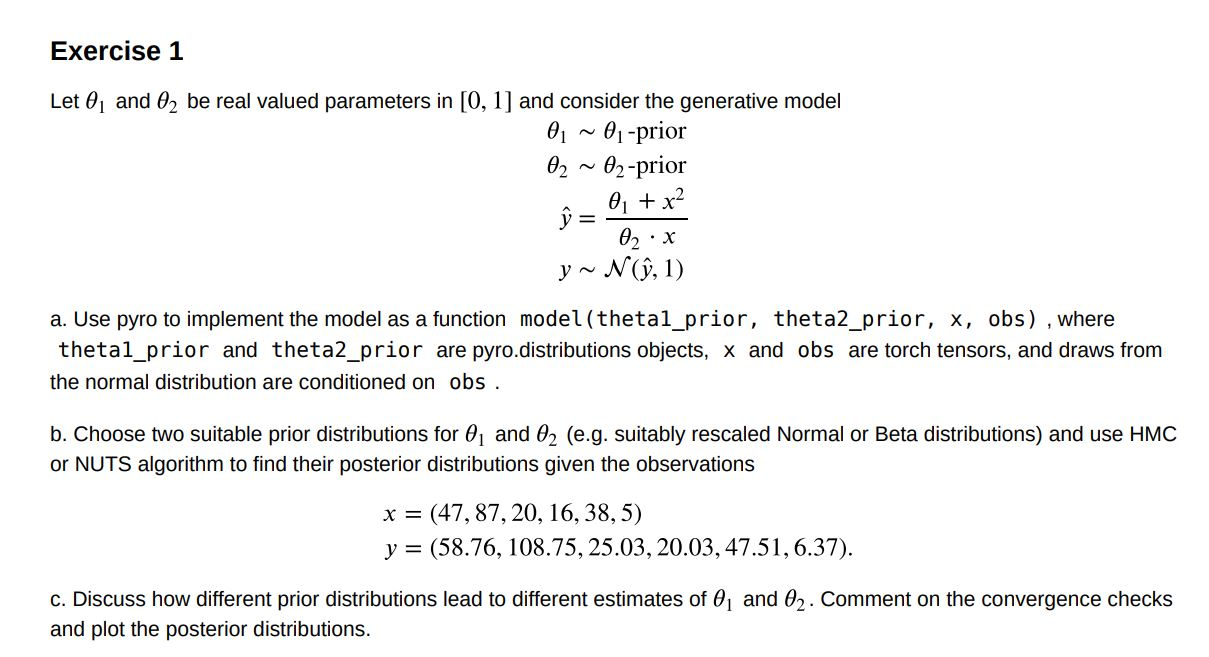

In [ ]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, HMC, NUTS
pyro.set_rng_seed(0)

In [ ]:
def model(theta1_prior, theta2_prior,x, y):
 theta1 = pyro.sample('theta1', theta1_prior)
 theta2 = pyro.sample('theta2', theta2_prior)
 
 y_hat = torch.divide(theta1.reshape(1,-1).t() + torch.pow(x,2), torch.mul(theta2.reshape(1,-1).t(),x))
 pyro.sample('obs', dist.Normal(y_hat, 1), obs=y)


x_data = [47, 87, 20, 16, 38, 5]
x = torch.tensor(x_data)

y_data = [58.76, 108.75, 25.03, 20.03, 47.51, 6.37]
y = torch.tensor(y_data)


print(model(dist.Normal(0, 1), dist.Normal(0, 5), x, y))

None


/usr/local/lib/python3.7/dist-packages/pyro/primitives.py:139: RuntimeWarning: trying to observe a value outside of inference at obs
  RuntimeWarning,


In [ ]:
kernel = NUTS(model)
mcmc = MCMC(kernel, warmup_steps=300, num_samples=100, num_chains=1)
mcmc.run(dist.Normal(0, 1), dist.Normal(0, 5), x, y)
#mcmc.summary()


Sample: 100%|██████████| 400/400 [00:03, 123.63it/s, step size=8.93e-01, acc. prob=0.914]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    theta1     -0.12      1.09     -0.27     -1.70      1.69     81.38      1.00
    theta2    -72.44      2.85    -72.76    -76.42    -67.69     99.33      0.99

Number of divergences: 0


3. Number of divergences is 0, means good convergence of both parameters. By observing the r_hat, since it is around 1.0, that the estimate is satisfying.

#todo plot

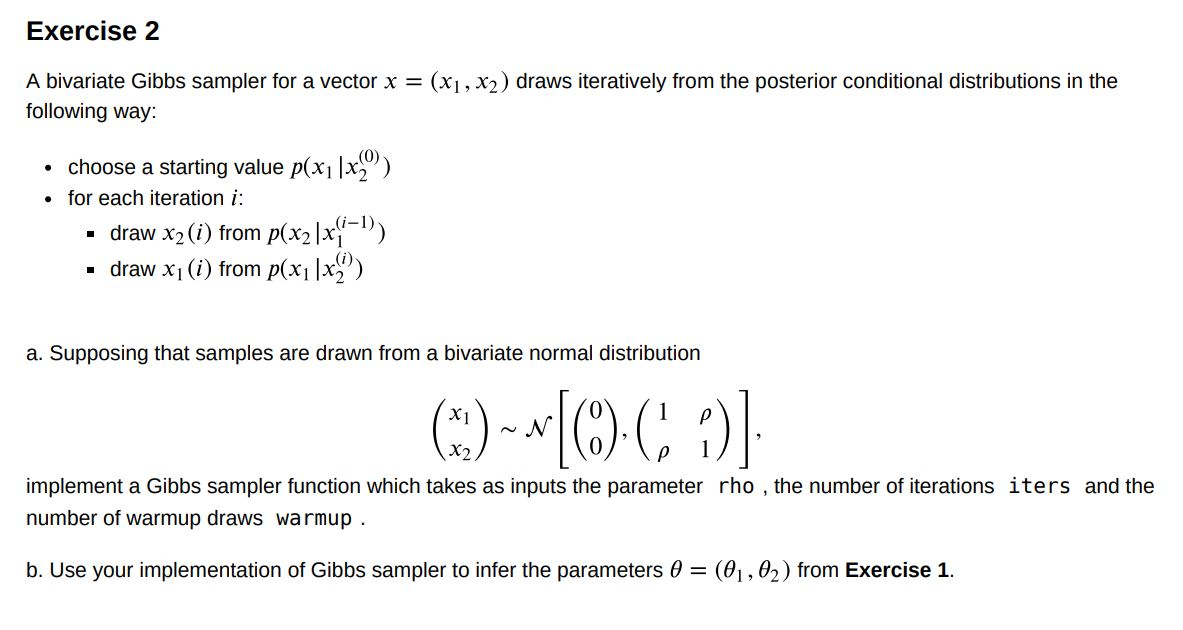

### Deriving the joint probability distribution, that is hard to sample from.

In its most common representation, a **multivariate normal distribution** over X1, . . . , Xn (x) is characterized by an n-dimensional mean vector µ, and a symmetric n × n covariance matrix Σ;
the density function is most often defined as:

$p(x) = \frac{1}{2\pi^{\frac{n}{2}}\sqrt{|Σ|}}\exp[-\frac{1}{2}(x - \mu)^TΣ^{-1}(x-\mu)]$

The determinant of the variance-covariance matrix $Σ$ in our case is $|Σ|=1-\rho^2$.

The joint probability of a **bivariate normal distribution** is:

$p(x_1, x_2) = \frac{1}{2\pi\sigma_{x_1}\sigma_{x_2}\sqrt{1-\rho^2}}\exp[-\frac{1}{2(1-\rho^2)}[(\frac{x_1 - \mu_{x_1}}{\mu_{x_1}}) ^2+ (\frac{x_2-\mu_{x_2}}{\mu_{x_2}})^2 - 2\rho(\frac{x_1-\mu_{x_1}}{\mu_{x_1}})(\frac{x_1-\mu_{x_1}}{\mu_{x_2}})]]$

From the mean and covariance matrix given, we conclude the samples are drawn from a bivariate standard normal distribution.

$x_1 \sim N(\mu_{x_1}, \sigma_{x_1}^2) \sim N(0,1)$
and
$x_2 \sim N(\mu_{x_2}, \sigma_{x_2}^2) \sim N(0,1)$

Therefore, for the **standard bivariate normal distribution** we write:
$p(x_1, x_2) = \frac{1}{2\pi\sqrt{1-\rho^2}}\exp[-\frac{x_1^2 + x_2^2 - 2\rho x_1 x_2}{2(1-\rho^2)}]$

--------------------------------
Relationship between z and x: If $x_1 \sim N(\mu_{x_1}, \sigma_{x_1}^2)$ then $z_1 = \frac{x_1 - \mu_{x_1}}{ \sigma_{x_1}} \sim N(0, 1)$ hence $x_1 = \sigma_{x_1}z_1 + \mu_{x_1}$. $x_2$ and by analogy $x_2 = \sigma_{x_2}z_2 + \mu_{x_2}$.


On rho: $corr(x_1, x_2) = \rho(x_1, x_2)= \rho = \frac{cov(x_1, x_2)}{\sigma_{x_1}\sigma_{x_2}} = \frac{E[(x_1 - E[x_1])(x_2 - E[x_2])]}{\sigma_{x_1}\sigma_{x_2}} = \frac{E[(\sigma_{x_1}z_1 + \mu_{x_1} - \mu_{x_1})(\sigma_{x_2}z_2 + \mu_{x_2} - \mu_{x_2})]}{\sigma_{x_1}\sigma_{x_2}} = E[z_1z_2] = \mu_{x_1}\mu_{x_2}$ . Hence, in our case, rho would be 0, since both mu values are 0.

-------------------------------------
### The conditional probability distributions are:

$p(x_1|x_2) = \frac{p(x_1, x_2)}{p(x_2)} = \frac{p(x_1, x_2)}{\frac{1}{\sqrt{2\pi}}exp[-\frac{x_2^2}{2}]} = \frac{1}{\sqrt{2\pi}(\sigma_{x_1}\sqrt{1-\rho^2})^2}\exp[-\frac{(x_1 - b_{x_2})^2}{2(\sigma_{x_1}\sqrt{1-\rho^2})^2}]$

where $b_{x_2} = \mu_{x_1} + \frac{\rho\sigma_{x_1}}{\sigma_{x_2}}(x_2-\mu_{x_2})$


\\
$p(x_2|x_1) = \frac{p(x_1, x_2)}{p(x_1)} = \frac{p(x_1, x_2)}{\frac{1}{\sqrt{2\pi}}exp[-\frac{x_1^2}{2}]} = \frac{1}{\sqrt{2\pi}(\sigma_{x_2}\sqrt{1-\rho^2})^2}\exp[-\frac{(x_2 - b_{x_1})^2}{2(\sigma_{x_2}\sqrt{1-\rho^2})^2}] $ 

where $b_{x_1} = \mu_{x_2} + \frac{\rho\sigma_{x_2}}{\sigma_{x_1}}(x_1-\mu_{x_1})$

\\

Thus, we can write:

$x_1|x_2 = x_2 \sim N(b_{x_2}, (\sigma_{x_1}\sqrt{1-\rho^2})^2)$

$x_2|x_1 = x_1 \sim N(b_{x_1}, (\sigma_{x_2}\sqrt{1-\rho^2})^2)$


In [4]:
import numpy as np
from random import random

In [5]:
def conditional_sampler(sampling_index, current_x, rho):
    conditioned_index = 1 - sampling_index 
    # The above line works because we only have 2 variables, x_0 & x_1
  
    mu = 0        
    sigma = (np.sqrt(1-(rho**2)))**2
    new_x = np.copy(current_x)
    #n samples from the correct conditional distribution
    new_x[sampling_index] = np.random.randn()*sigma + mu
    return new_x


In [30]:
def gibbs_sampler(rho, iters, warmup):

    point = [2, 0.6]
    samples = np.empty([iters+1, 2])  #sampled points
    samples[0] = point
    tmp_points = np.empty([iters, 2]) #inbetween points

    for i in range(iters):
        # Sample from p(x_1|x_2)
        point = conditional_sampler(0, point, rho)
        tmp_points[i] = point
        # Sample from p(x_2|x_1)
        point = conditional_sampler(1, point, rho)
        samples[i+1] = point

    return samples[warmup:], tmp_points

# test function without linear transformations

iters = 10020
rho = 0 # rho 0 for the case of bivariate standard normal distribution case
warmup = 20
samples, tmp_points = gibbs_sampler(rho, iters, warmup)

samples

array([[-1.19507574, -2.83420658],
       [-0.61157177,  1.52176616],
       [ 0.19192074,  0.43250434],
       ...,
       [-0.25453648, -0.3037978 ],
       [ 0.53733471, -0.61646221],
       [-1.70915919,  0.44210096]])

In [31]:
print(np.mean(samples, axis=0))
print(np.cov(np.transpose(samples)))

[ 0.00877179 -0.00051468]
[[0.99294195 0.00543209]
 [0.00543209 1.00533169]]
